In [ ]:
!pip install transformers datasets torchaudio --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Transformers library
from transformers import (
    Wav2Vec2ForSequenceClassification,
    Wav2Vec2Processor,
    Wav2Vec2FeatureExtractor,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)

In [ ]:
# PyTorch
import torch
from torch.utils.data import DataLoader

# Dataset handling
from datasets import Dataset, Audio

# Metrics
from sklearn.metrics import accuracy_score
import numpy as np

# File handling
import os
import shutil
import json

# Audio processing
import soundfile as sf

# Randomization
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ls '/content/drive/MyDrive/Deep_Project/'

## Here we train on the OG DATASET:

In [ ]:
import json
from collections import Counter

In [ ]:
output_file = "/content/drive/My Drive/Deep_Project/labeled_data.json"

In [ ]:
# Load the JSON file
with open(output_file, "r") as f:
    data = json.load(f)

# Print the first 5 samples
print("First 5 samples:")
for sample in data[:5]:
    print(sample)

# Check the total number of samples
num_samples = len(data)
print(f"\nTotal number of samples: {num_samples}")

# Inspect keys in one sample
if num_samples > 0:
    print("\nKeys in a sample:")
    print(list(data[0].keys()))
    print("\nExample sample:")
    print(data[0])

# Check accent distribution
accent_distribution = Counter([entry["accent"] for entry in data])
print("\nAccent distribution:")
for accent, count in accent_distribution.items():
    print(f"{accent}: {count}")


First 5 samples:
{'file_path': '/content/drive/My Drive/Deep_Project/new_data/speaker1/arctic_b0418.wav', 'speaker': 'speaker1', 'accent': 'Arabic'}
{'file_path': '/content/drive/My Drive/Deep_Project/new_data/speaker1/arctic_b0121.wav', 'speaker': 'speaker1', 'accent': 'Arabic'}
{'file_path': '/content/drive/My Drive/Deep_Project/new_data/speaker1/arctic_a0474.wav', 'speaker': 'speaker1', 'accent': 'Arabic'}
{'file_path': '/content/drive/My Drive/Deep_Project/new_data/speaker1/arctic_b0029.wav', 'speaker': 'speaker1', 'accent': 'Arabic'}
{'file_path': '/content/drive/My Drive/Deep_Project/new_data/speaker1/arctic_a0390.wav', 'speaker': 'speaker1', 'accent': 'Arabic'}

Total number of samples: 856

Keys in a sample:
['file_path', 'speaker', 'accent']

Example sample:
{'file_path': '/content/drive/My Drive/Deep_Project/new_data/speaker1/arctic_b0418.wav', 'speaker': 'speaker1', 'accent': 'Arabic'}

Accent distribution:
Arabic: 431
Spanish: 425


# Validate the DataSet

In [ ]:
import soundfile as sf

In [ ]:
def is_valid_audio(file_path, current_speaker=None, last_speaker=None):
    try:
        # Log progress when the speaker changes
        if current_speaker != last_speaker:
            print(f"Processing files for speaker: {current_speaker}")

        # Open the file in "read mode" without loading it fully
        with sf.SoundFile(file_path, mode="r") as f:
            pass  # Successfully opened, no need to read data
        return True, current_speaker

    except Exception as e:
        # Log the problematic file and speaker
        print(f"Invalid file detected for speaker {current_speaker}: {file_path}, Error: {e}")
        return False, current_speaker


In [ ]:
# Maximum number of files per speaker
MAX_FILES_PER_SPEAKER = 100

# Initialize a dictionary to track the number of files processed per speaker
speaker_file_count = {}

valid_data = []  # Store valid files

for item in data:
    speaker = item["speaker"]

    # Initialize the counter for the speaker if not already done
    if speaker not in speaker_file_count:
        speaker_file_count[speaker] = 0

    # Skip files if the maximum limit is reached for the speaker
    if speaker_file_count[speaker] >= MAX_FILES_PER_SPEAKER:
        continue

    # Check the validity of the file
    is_valid, current_speaker = is_valid_audio(
        item["file_path"],
        current_speaker=speaker,
        last_speaker=None,  # Not needed for this use case
    )

    if is_valid:
        valid_data.append(item)
        speaker_file_count[speaker] += 1  # Increment the counter for the speaker

print(f"Valid data collected for {len(speaker_file_count)} speakers.")



Processing files for speaker: speaker1
Processing files for speaker: speaker1
Processing files for speaker: speaker1
Processing files for speaker: speaker1
Processing files for speaker: speaker1
Processing files for speaker: speaker1
Processing files for speaker: speaker1
Processing files for speaker: speaker1
Processing files for speaker: speaker1
Processing files for speaker: speaker1
Processing files for speaker: speaker1
Processing files for speaker: speaker1
Processing files for speaker: speaker1
Processing files for speaker: speaker1
Processing files for speaker: speaker1
Processing files for speaker: speaker1
Processing files for speaker: speaker1
Processing files for speaker: speaker1
Processing files for speaker: speaker1
Processing files for speaker: speaker1
Processing files for speaker: speaker1
Processing files for speaker: speaker1
Processing files for speaker: speaker1
Processing files for speaker: speaker1
Processing files for speaker: speaker1
Processing files for spea

# Make the data compatible to work with huggingface & Add the linear layer to make our model supervised and good for classification

In [ ]:
from transformers import Wav2Vec2FeatureExtractor

In [ ]:
# Convert the filtered data into a Hugging Face Dataset
dataset = Dataset.from_list(valid_data)

# Ensure all audio files are loaded with the correct sampling rate
dataset = dataset.cast_column("file_path", Audio(sampling_rate=16000))

In [ ]:
# Load Wav2Vec2 feature extractor
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-large-xlsr-53")

# Map labels to integers
unique_accents = dataset.unique("accent")
label2id = {label: i for i, label in enumerate(unique_accents)}
id2label = {i: label for label, i in label2id.items()}

# ensure correct accents
print(f"Unique accents: {unique_accents}")
print(f"Label to ID mapping: {label2id}")
print(f"ID to Label mapping: {id2label}")

# Preprocessing function
def preprocess(batch):
    # Load audio and extract input values
    audio = batch["file_path"]["array"]
    inputs = feature_extractor(audio, sampling_rate=16000, return_tensors="pt", padding=True)
    batch["input_values"] = inputs.input_values[0]
    batch["labels"] = label2id[batch["accent"]]
    return batch

# Apply preprocessing
dataset = dataset.map(preprocess, remove_columns=["file_path", "accent", "speaker"])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

Unique accents: ['Arabic', 'Spanish']
Label to ID mapping: {'Arabic': 0, 'Spanish': 1}
ID to Label mapping: {0: 'Arabic', 1: 'Spanish'}


Map:   0%|          | 0/793 [00:00<?, ? examples/s]

# Split Dataset into Training and Testing Sets

In [ ]:
# Split the dataset
train_test_split = dataset.train_test_split(test_size=0.2)
train_dataset = train_test_split["train"]
test_dataset = train_test_split["test"]

# Print the number of samples
print(f"Number of samples in the training set: {len(train_dataset)}")
print(f"Number of samples in the validation set: {len(test_dataset)}")

Number of samples in the training set: 634
Number of samples in the validation set: 159


#Define the model

In [ ]:
# Load pre-trained Wav2Vec2 model for classification
model = Wav2Vec2ForSequenceClassification.from_pretrained(
    "facebook/wav2vec2-large-xlsr-53",
    num_labels=len(unique_accents),
    label2id=label2id,
    id2label=id2label,
)

config.json:   0%|          | 0.00/1.77k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-large-xlsr-53 and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#Accuracy metrices

In [ ]:
# Define accuracy metric
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy}


#Training arguments

In [ ]:
from transformers import TrainingArguments
import torch

In [ ]:
# Define training arguments

training_args = TrainingArguments(
    output_dir="./results",               # Directory to save model and results
    evaluation_strategy="epoch",          # Evaluate at the end of each epoch
    logging_strategy="steps",             # Log every `logging_steps`
    logging_steps=10,                     # Log every 10 steps
    learning_rate=2e-5,                   # Learning rate
    per_device_train_batch_size=8,        # Batch size for training
    per_device_eval_batch_size=8,         # Batch size for evaluation
    num_train_epochs=20,                   # Total number of epochs
    weight_decay=0.01,                    # Weight decay
    save_strategy="epoch",                # Save model at each epoch
    logging_dir="./logs",                 # Directory for logs
    load_best_model_at_end=True,          # Load the best model at the end
    metric_for_best_model="accuracy",     # Metric for selecting the best model
    report_to="none",                     # Disable logging to external services
    fp16=True,  # Enable mixed precision training - GET RID OF THIS FOR ACCURACY!!!!!!!!!!!!!!!
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=feature_extractor,  # Use feature extractor
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],  # Add early stopping
)


<ipython-input-19-56aa67bbf19c>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
if torch.cuda.is_available():
    print(f"GPU is available: {torch.cuda.get_device_name(0)}")
else:
    print("No GPU found. Please enable GPU in runtime settings.")

# Check the device being used by PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

GPU is available: Tesla T4
Using device: cuda


# TRAINING

In [ ]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.691700,0.693620,0.452830
2,0.677600,0.691667,0.729560
3,0.665000,0.683446,0.754717
4,0.504700,0.544255,0.899371
5,0.291300,0.104715,0.993711
6,0.050600,0.039899,0.993711
7,0.022900,0.005529,1.000000
8,0.046400,0.034712,0.993711
9,0.004300,0.006570,0.993711


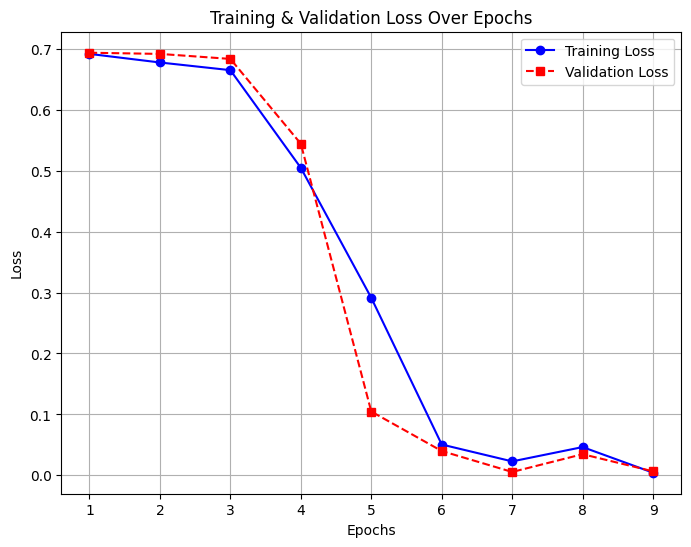

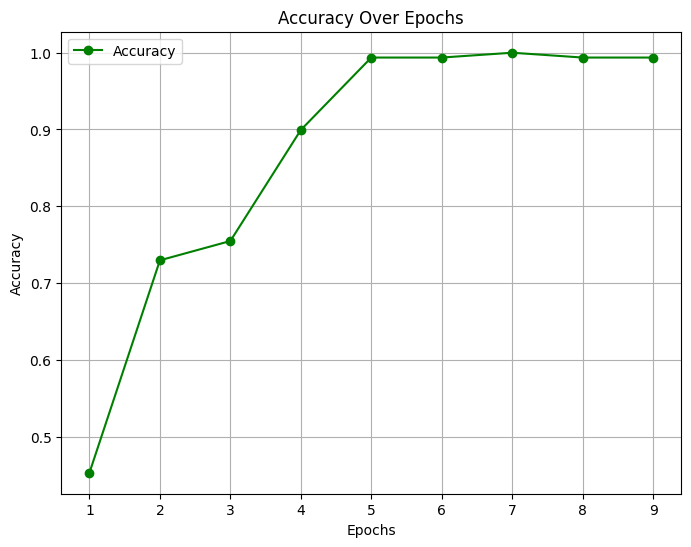

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data extracted from the image
epochs = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])
training_loss = np.array([0.6917, 0.6776, 0.665, 0.5047, 0.2913, 0.0506, 0.0229, 0.0464, 0.0043])
validation_loss = np.array([0.69362, 0.691667, 0.683446, 0.544255, 0.104715, 0.039899, 0.005529, 0.034712, 0.00657])
accuracy = np.array([0.45283, 0.72956, 0.754717, 0.899371, 0.993711, 0.993711, 1.000000, 0.993711, 0.993711])

# Create the figure and axis
plt.figure(figsize=(8, 6))

# Plot training and validation loss
plt.plot(epochs, training_loss, label="Training Loss", marker='o', linestyle='-', color='blue')
plt.plot(epochs, validation_loss, label="Validation Loss", marker='s', linestyle='--', color='red')

# Set labels and title
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Over Epochs")
plt.legend()
plt.grid(True)

# Show the loss plot
plt.show()

# Plot accuracy
plt.figure(figsize=(8, 6))
plt.plot(epochs, accuracy, label="Accuracy", marker='o', linestyle='-', color='green')

# Set labels and title
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Epochs")
plt.legend()
plt.grid(True)

# Show the accuracy plot
plt.show()


In [ ]:
# Evaluate the model
results = trainer.evaluate()
print(f"Test Accuracy: {results['eval_accuracy']:.4f}")

In [ ]:
# Save the model and feature extractor
model.save_pretrained("/content/drive/My Drive/Deep_Project/saved_models")
feature_extractor.save_pretrained("/content/drive/My Drive/Deep_Project/saved_models")

print("Model and feature extractor saved to Google Drive!")

Model and feature extractor saved to Google Drive!


# TRY ON TEST DATA

In [ ]:
import torch
from transformers import Wav2Vec2FeatureExtractor
import numpy as np
from sklearn.metrics import accuracy_score
from datasets import Dataset
from datasets import Audio
import json


In [ ]:
# Define the path to the JSON file
json_file_path = '/content/drive/My Drive/test_data.json'

# Load the JSON file and convert it into a list
with open(json_file_path, 'r') as json_file:
    test_data_list = json.load(json_file)

In [ ]:
# Step 1: Load test_data.json
json_file_path = '/content/drive/My Drive/test_data.json'
with open(json_file_path, 'r') as json_file:
    test_data_list = json.load(json_file)

print(f"\n✅ Loaded Test Data: {len(test_data_list)} samples")

# Step 2: Convert the test data to a Hugging Face Dataset
test_dataset = Dataset.from_list(test_data_list)

# Step 3: Load the feature extractor used during training
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("/content/drive/My Drive/Deep_Project/saved_models")



✅ Loaded Test Data: 264 samples


In [ ]:
# Step 4: Preprocess test data
# Preprocess the test dataset
def preprocess_test_data(batch):
    # Convert audio to tensor using the feature extractor
    audio = batch["file_path"]["array"]
    features = feature_extractor(audio, sampling_rate=16000, return_tensors="pt", padding=True)
    batch["input_values"] = features.input_values[0]  # Extract the input_values tensor
    batch["labels"] = 1 if batch["accent"].lower() == "spanish" else 0  # Add labels
    return batch

# Apply preprocessing
test_dataset = test_dataset.cast_column("file_path", Audio(sampling_rate=16000))
test_dataset = test_dataset.map(preprocess_test_data, remove_columns=["file_path", "accent"])

# Step 5: Load the trained model
from transformers import Wav2Vec2ForSequenceClassification

model = Wav2Vec2ForSequenceClassification.from_pretrained(
    "/content/drive/My Drive/Deep_Project/saved_models"
)
model.eval()

Map:   0%|          | 0/264 [00:00<?, ? examples/s]

ImportError: cannot import name 'DataLoade' from 'torch.utils.data' (/usr/local/lib/python3.11/dist-packages/torch/utils/data/__init__.py)

In [ ]:
# Step 6: Define a function to evaluate the model
from torch.utils.data import DataLoader

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(
    tokenizer=feature_extractor,  # Use Wav2Vec2 feature extractor
    padding=True,
    max_length=16000,  # Set a reasonable max length in samples
)

In [ ]:
# Move the model to the GPU and enable gradient checkpointing
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.gradient_checkpointing_enable()  # Enable gradient checkpointing to save memory


# Evaluate the model
def evaluate_model(dataset, model):
    model.eval()  # Set model to evaluation mode
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=2, collate_fn=data_collator)

    predictions = []
    labels = []

    # Clear CUDA cache to prevent fragmentation
    torch.cuda.empty_cache()

    for batch in dataloader:
        # Move input values and labels to the correct device
        input_values = batch["input_values"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels.extend(batch["labels"])  # Collect true labels

        with torch.no_grad():
            outputs = model(input_values=input_values, attention_mask=attention_mask).logits
            preds = torch.argmax(outputs, dim=-1).cpu().tolist()
            predictions.extend(preds)

    # Compute accuracy
    accuracy = accuracy_score(labels, predictions)
    print(f"\n✅ Test Dataset Accuracy: {accuracy * 100:.2f}%")
    return accuracy

# Evaluate the model
test_accuracy = evaluate_model(test_dataset, model)


✅ Test Dataset Accuracy: 41.29%
